# Лабораторные работы №6-8
## Лабораторная работа №6 (Проведение исследований с моделями классификации)
### Выполнил студент группы М8О-406Б-21, Карнаков Н.Д.


Для выполнения данной лабораторной работы был выбран датасет с Kaggle - https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia.

Набор данных "Рентгеновские снимки грудной клетки (пневмония)" может использоваться для тренировки моделей, способных классифицировать пневманию по рентгеновским снимкам. Автоматизация процесса классификации пневмании может улучшить уход за пациентами и помочь медицинским работникам принимать обоснованные решения в краткие сроки.

Рентгеновские снимки грудной клетки (передне-задние) были отобраны из ретроспективной когорты педиатрических пациентов в возрасте от одного года до пяти лет из Женского и детского медицинского центра Гуанчжоу, Гуанчжоу. Все рентгеновские снимки грудной клетки выполнялись в рамках рутинного клинического наблюдения за пациентами.

Для анализа рентгеновских снимков грудной клетки все рентгенограммы грудной клетки были первоначально проверены на предмет контроля качества путем удаления всех некачественных или нечитаемых снимков. Затем диагнозы на снимках оценивались двумя врачами-экспертами, после чего они допускались к обучению системы искусственного интеллекта. Для того чтобы учесть любые ошибки в оценке, набор оценок также проверялся третьим экспертом.


Пневмония - это воспалительное заболевание легких, поражающее в первую очередь маленькие воздушные мешочки, называемые альвеолами. Симптомы обычно включают в себя сочетание продуктивного или сухого кашля, боли в груди, лихорадки и затрудненного дыхания. Тяжесть заболевания может быть разной. Пневмония обычно вызывается инфекцией, вызванной вирусами или бактериями, реже - другими микроорганизмами, некоторыми лекарствами или состояниями, такими как аутоиммунные заболевания. Факторы риска включают муковисцидоз, хроническую обструктивную болезнь легких (ХОБЛ), астму, диабет, сердечную недостаточность, историю курения, плохую способность откашливаться, например, после инсульта, и слабую иммунную систему. Диагноз часто ставится на основании симптомов и физического осмотра. Рентгенография грудной клетки, анализы крови и культура мокроты могут помочь подтвердить диагноз. Заболевание может быть классифицировано по месту его приобретения, например, как внутриобщинная, внутрибольничная или связанная с медицинским обслуживанием пневмония.

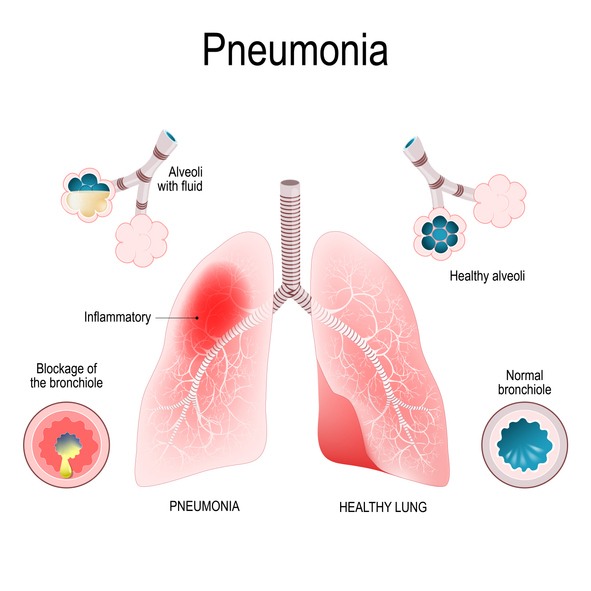

# 1.	Выбор начальных условий

Первым делом загрузим наш датасет

In [1]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


Импортируем необходимые библиотеки для нашего начала работы

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np

Набор данных организован в 3 папки (train, test, val) и содержит вложенные папки для каждой категории изображений (пневмония/норма). Имеется 5 863 рентгеновских снимка (JPEG) и 2 категории (пневмония/норма).

Начнем с определения двух ключевых параметров: списка меток labels = ['PNEUMONIA', 'NORMAL'] и размера изображения img_size = 150. Список labels задаёт имена директорий, в которых хранятся снимки каждого класса, а индекс каждого элемента списка (0 или 1) используется в качестве числовой метки при обучении модели. Параметр img_size отвечает за то, к какому разрешению будут приведены все входные изображения, обеспечивая их единообразие.

Функция get_training_data(data_dir) обходит указанный каталог data_dir, содержащий подпапки с названиями из labels. Для каждого класса она формирует путь к папке и вычисляет соответствующую числовую метку class_num. Затем внутри этой папки с помощью os.listdir последовательно перебираются все файлы-изображения. Каждое изображение загружается через OpenCV в оттенках серого (cv2.IMREAD_GRAYSCALE), что упрощает структуру данных и уменьшает объём вычислений по сравнению с цветными изображениями. Если файл не удаётся загрузить (например, он повреждён или не является изображением), печатается предупреждение, и такой файл пропускается.

После успешного чтения каждое изображение приводится к квадратному виду заданного размера — в данном случае 150×150 пикселей — с помощью cv2.resize. Это важно для последующей подачи данных в нейронную сеть, поскольку большинство архитектур ожидают на вход тензоры одинаковой формы. Подготовленные массивы пикселей затем объединяются с их числовыми метками в единую структуру: пара [resized_arr, class_num] добавляется в список data.

Наконец, после итерации по всем классам и файлам список data, содержащий пары «массив пикселей – метка», преобразуется в объект NumPy (np.array(data, dtype=object)) и возвращается из функции. В результате мы получаем готовый для обучения набор данных, где все изображения имеют одинаковый размер и формат, а каждый пример снабжён корректной числовой меткой.

In [20]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in os.listdir(path):
            full_path = os.path.join(path, img_name)
            img_arr = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            if img_arr is None:
                print(f"Warning: cannot read image {full_path}, skipping")
                continue
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, class_num])
    return np.array(data, dtype=object)



Вызовем трижды функцию get_training_data для загрузки и предобработки изображений из разных подпапок набора данных. В каждой строчке в переменную (train, test или val) сохраняется результат работы функции — массив пар «изображение + метка», где изображения приведены к единому размеру и формату, а метки соответствуют классам.

В первой строке train = get_training_data('…/train') происходит чтение и подготовка данных обучающего множества. Это те снимки, на которых модель будет учиться распознавать пневмонию и здоровые лёгкие. Функция обходит папки PNEUMONIA и NORMAL внутри каталога train, конвертирует каждый файл в градации серого, меняет размер до 150×150 и присваивает числовую метку.

Аналогично во второй и третьей строках обрабатываются тестовый и валидационный наборы: test = get_training_data('…/test') готовит данные для финальной оценки модели, а val = get_training_data('…/val') формирует выборку для промежуточной проверки качества во время обучения. В результате у вас есть три массива данных, готовых к подаче в модель на разных этапах её работы.

In [21]:
train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val')

Визуализируем отношения количества изображений с пневмонией и нормальной грудной клеткой

<Axes: xlabel='count'>

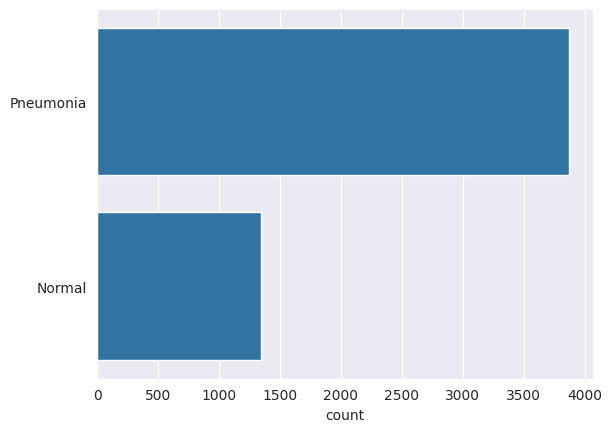

In [22]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Теперь визуализируем два изображения для примера

Text(0.5, 1.0, 'NORMAL')

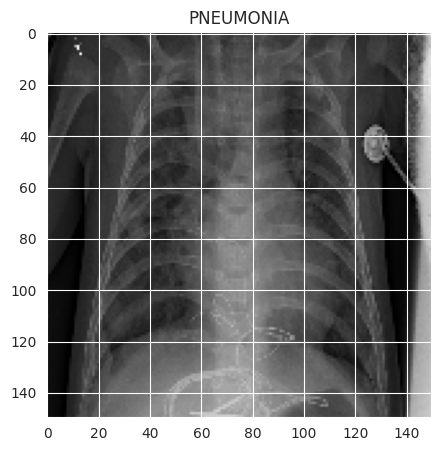

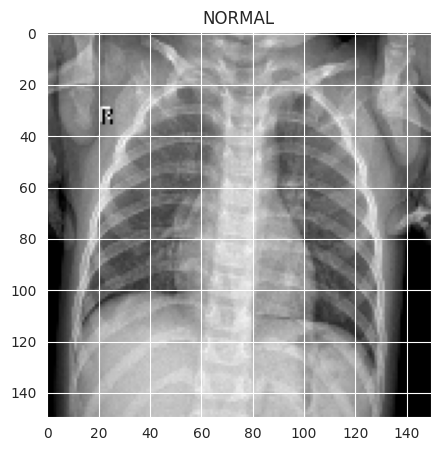

In [23]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

Теперь импортируем необходимые библиотеки для обучения наших моделей

In [50]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, precision_recall_curve, auc)
from tqdm import tqdm
import matplotlib.pyplot as plt

### Выбор метрик

Для оценки качества моделей классификации в этой задаче будем использовать следующие метрики

Матрица ошибок (Confusion Matrix) — даёт полное представление о количестве истинно/ложно положительных и отрицательных решений, что важно в медицине, чтобы понимать, где именно модель ошибается.

Точность (Accuracy) - доля правильных предсказаний. Полезна как базовая метрика, но в условиях дисбаланса она может вводить в заблуждение (модель, всегда предсказывающая «пневмония», получит высокую точность).

Полнота (Recall, Sensitivity) - доля правильно найденных случаев пневмонии среди всех реальных случаев пневмонии: 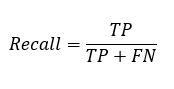

В нашей задаче особенно важно не пропустить больных (минимизировать FN), поэтому приоритизируем высокую полноту.

Точность позитивных предсказаний (Precision) - доля правильно распознанных пневмоний среди всех примеров, где модель предсказала «пневмония».

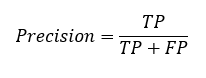

Высокая precision помогает избежать ложных тревог и ненужных обращений к врачу.

F1-мера ->  гармоническое среднее precision и recall:

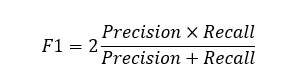

Балансирует между пропущенными случаями и ложными срабатываниями.

ROC-AUC (Area Under ROC Curve) - интегральная метрика, не зависящая от порога классификации. Показывает, насколько хорошо модель умеет разделять классы в целом.

PR-AUC (Area Under Precision-Recall Curve) - особенно информативна при сильном дисбалансе классов: фокусируется на поведении precision и recall при разных порогах.

### Почему именно эти метрики?

Дисбаланс классов. Accuracy может быть обманчива, поэтому нужны recall и precision, а также их агрегированная F1.

Медицинский контекст. Пропущенный больной (FN) — критическая ошибка, значит приоритет на высокую полноту (recall). С другой стороны, слишком много ложных тревог (FP) приведёт к ненужным обследованиям, поэтому важна и precision.

Пороговая независимость. ROC-AUC и PR-AUC дают общую картину качества без привязки к конкретному порогу, что позволяет сравнивать модели на «грубом» уровне.

# 2.	Создание бейзлайна и оценка качества

### Настройка путей и гиперпараметров

Зададим основные параметры и пути к данным. Сначала определим корневую папку с изображениями DATA_DIR, а на её основе сформируем пути к папкам для обучения, валидации и теста. Это упростит дальнейшую работу с файлами.

Далее установим ключевые гиперпараметры обучения: число классов (NUM_CLASSES = 2), размер батча (BATCH_SIZE = 16), число эпох (NUM_EPOCHS = 5) и скорость обучения (LR = 1e−4). Эти значения управляют тем, как модель будет обучаться.

Переменная DEVICE определяет, будет ли вычисление вестись на GPU (если доступен CUDA) или на CPU. Наконец, SUBSET_FACTOR = 0.05 указывает, что для ускорения эксперимента мы возьмём только 5 % от всего обучающего набора.

In [52]:
DATA_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')
NUM_CLASSES = 2
BATCH_SIZE = 16
NUM_EPOCHS = 5
LR = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SUBSET_FACTOR = 0.05

### Трансформация данных

Далее создадим два набора преобразований для изображений с помощью torchvision.transforms. Первый набор train_transforms применим к обучающим данным: каждое изображение сначала изменится до размера 224×224 пикселя, затем случайно отразим по горизонтали (осуществим процесс аугментации для повышения разнообразия выборки), после чего конвертируем в тензор PyTorch и нормализуем по каналам по средним и стандартным отклонениям, принятым в предобученных моделях.

Второй набор val_transforms почти идентичен, но без шага аугментации: он только изменяет размер до 224×224, переводит в тензор и выполняет ту же нормализацию. Это гарантирует, что на валидации и тесте модель видит изображения в том же формате, но без случайных искажений.

In [41]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Загрузка и сокращение датасетов

Сначала мы создаём три объекта ImageFolder: для обучения (full_train_dataset), валидации и теста. При этом каждому из них автоматически присваиваются метки на основе подпапок (PNEUMONIA/NORMAL), а к изображениям применяются заранее определённые преобразования (train_transforms для обучения и val_transforms для валидации и теста).

Затем рассчитываем размер сокращённого обучающего подмножества: subset_size = 5 % от полного числа изображений, а оставшуюся часть отбрасываем через random_split. Таким образом ускоряется эксперимент, поскольку модель видит только небольшую часть данных. Вывод в консоль информирует, сколько примеров используется.

Наконец, на основе готовых наборов формируем три загрузчика (DataLoader): для обучения — с перемешиванием батчей (shuffle=True), и для валидации/теста — без перемешивания. Каждый загрузчик отдаёт батчи размера BATCH_SIZE, упрощая подачу данных в цикл тренировки и оценки.

In [42]:
full_train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

subset_size = int(len(full_train_dataset) * SUBSET_FACTOR)
remaining_size = len(full_train_dataset) - subset_size
train_dataset, _ = random_split(full_train_dataset, [subset_size, remaining_size])
print(f"Используем {subset_size} из {len(full_train_dataset)} обучающих образцов для ускорения обучения.")

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
}

Используем 260 из 5216 обучающих образцов для ускорения обучения.


### Функция создания моделей

Функция get_model принимает на вход строку name, задающую архитектуру, и число классов num_classes. В зависимости от значения name она инициализирует либо ResNet-18, либо ViT-B_16 с предобученными на ImageNet весами.

В случае resnet18 из модуля torchvision.models загружается стандартная ResNet-18. Поскольку её последним слоем по умолчанию является полносвязный слой на 1000 классов, мы заменяем его (model.fc) на новый nn.Linear с числом выходов, равным num_classes.

Для vit_b_16 (Vision Transformer) берётся модель vit_b_16 с предобучением, и аналогичным образом модифицируется её классификационная голова: заменяем model.heads.head на линейный слой с нужным числом выходов.

Если имя модели не опознано, выбрасывается исключение ValueError, чтобы сразу заметить опечатку или неправильный аргумент. Наконец, модель переводится на устройство DEVICE (GPU, если доступен CUDA, иначе CPU) и возвращается из функции.

In [43]:
def get_model(name, num_classes):
    if name == 'resnet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == 'vit_b_16':
        model = models.vit_b_16(pretrained=True)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return model.to(DEVICE)

### Функция обучения

Функция train_model запускает цикл обучения модели на заданное число эпох. В начале каждой итерации она переводит модель в режим обучения (model.train()), обнуляет накопленный loss и создаёт прогресс-бар tqdm для батчей из dataloaders['train'].

Внутри цикла по батчам каждый пакет изображений и меток переносится на устройство (DEVICE), после чего обнуляются градиенты оптимизатора, делается прямой проход (outputs = model(images)), вычисляется функция потерь (criterion) и выполняется обратное распространение ошибки (loss.backward()). Оптимизатор обновляет параметры модели командой optimizer.step(). Текущий loss добавляется к суммарному и выводится в прогресс-бар.

После обработки всех батчей рассчитывается средний loss за эпоху и печатается в консоль. Далее вызывается evaluate_model для проверки модели на валидационном наборе: выводятся основные метрики (accuracy, precision, recall, F1-score, ROC-AUC и PR-AUC). По завершении всех эпох функция возвращает дообученную модель.

In [47]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            loop.set_postfix(loss=loss.item())
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_loss:.4f}")
        val_metrics = evaluate_model(model, dataloaders['val'])
        print(
            f"Validation - Acc: {val_metrics['accuracy']:.4f}, "
            f"Prec: {val_metrics['precision']:.4f}, Rec: {val_metrics['recall']:.4f}, "
            f"F1: {val_metrics['f1']:.4f}, ROC-AUC: {val_metrics['roc_auc']:.4f}, PR-AUC: {val_metrics['pr_auc']:.4f}"
        )
    return model

### Функция оценки и расчет метрик

Функция evaluate_model переводит модель в режим оценки (model.eval()) и отключает вычисление градиентов (torch.no_grad()), чтобы ускорить вывод и снизить потребление памяти. Затем она последовательно пробегает по батчам из переданного dataloader, перемещая изображения на DEVICE и получая сырые выходы модели.

Для каждого батча из выходов вычисляются вероятности класса «пневмония» через softmax (берётся второй столбец) и итоговые предсказанные метки через argmax. Эти массивы вероятностей и предсказаний вместе с истинными метками собираются в три списка: all_probs, all_preds и all_labels.

После прохождения всех примеров на основе собранных списков считаются ключевые метрики: точность (accuracy), precision, recall, F1-мера, ROC-AUC (по вероятностям) и PR-AUC (площадь под кривой «precision-recall»). Также строится матрица ошибок (confusion_matrix), показывающая число истинно/ложно положительных и отрицательных случаев. Все эти значения упаковываются в словарь и возвращаются для удобного анализа и сравнения моделей.

In [48]:
def evaluate_model(model, dataloader):
    model.eval()
    all_labels, all_probs, all_preds = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall_curve, precision_curve)
    cm = confusion_matrix(all_labels, all_preds)
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }

### Основной запуск обучения

Этот блок кода определяет точку входа скрипта: он выполняется только при прямом запуске файла, а не при импорте как модуля. Здесь задаётся список архитектур model_names и создаётся пустой словарь results для хранения метрик каждой модели.

В цикле по именам моделей для каждой архитектуры сначала выводится сообщение о начале обучения, затем создаётся экземпляр модели через функцию get_model, задаётся функция потерь CrossEntropyLoss и оптимизатор Adam с заданным шагом обучения. После этого вызывается train_model, которая обучает модель на тренировочном наборе и выводит метрики валидации по эпохам.

По завершении обучения для каждой модели делается оценка на тестовом наборе через evaluate_model, результаты которой сохраняются в словарь results под ключом с именем модели. Наконец, в консоль выводится словарь метрик, позволяющий сравнить поведение разных архитектур.

In [51]:
if __name__ == '__main__':
    model_names = ['resnet18', 'vit_b_16']
    results = {}

    for name in model_names:
        print(f"\nTraining baseline model: {name}")
        model = get_model(name, NUM_CLASSES)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        model = train_model(model, dataloaders, criterion, optimizer, NUM_EPOCHS)
        print(f"Evaluating model {name} on test set:")
        metrics = evaluate_model(model, dataloaders['test'])
        results[name] = metrics
        print(metrics)

    # Вывод сравнительных результатов
    for name, m in results.items():
        print(f"\n{name} metrics:")
        for k, v in m.items():
            if k != 'confusion_matrix':
                print(f"  {k}: {v:.4f}")
        print(f"  confusion_matrix:\n{m['confusion_matrix']}")



Training baseline model: resnet18


Epoch 1/5 - Training Loss: 0.3162
Validation - Acc: 0.6250, Prec: 0.5714, Rec: 1.0000, F1: 0.7273, ROC-AUC: 0.9062, PR-AUC: 0.8617


Epoch 2/5 - Training Loss: 0.1036
Validation - Acc: 0.6250, Prec: 0.5714, Rec: 1.0000, F1: 0.7273, ROC-AUC: 0.9688, PR-AUC: 0.9685


Epoch 3/5 - Training Loss: 0.0630
Validation - Acc: 0.6250, Prec: 0.5714, Rec: 1.0000, F1: 0.7273, ROC-AUC: 0.9844, PR-AUC: 0.9852


Epoch 4/5 - Training Loss: 0.0413
Validation - Acc: 0.6875, Prec: 0.6154, Rec: 1.0000, F1: 0.7619, ROC-AUC: 1.0000, PR-AUC: 1.0000


Epoch 5/5 - Training Loss: 0.0163
Validation - Acc: 0.8125, Prec: 0.7273, Rec: 1.0000, F1: 0.8421, ROC-AUC: 1.0000, PR-AUC: 1.0000
Evaluating model resnet18 on test set:
{'accuracy': 0.782051282051282, 'precision': 0.7461240310077519, 'recall': 0.9871794871794872, 'f1': 0.8498896247240618, 'roc_auc': np.float64(0.9445868945868945), 'pr_auc': np.float64(0.9599071156361776), 'confusion_matrix': array([[103, 131],
       [  5, 385]])}

Training baseline model: vit_b_16


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 47.7MB/s]


Epoch 1/5 - Training Loss: 0.4900
Validation - Acc: 0.8750, Prec: 0.8000, Rec: 1.0000, F1: 0.8889, ROC-AUC: 0.9688, PR-AUC: 0.9685


Epoch 2/5 - Training Loss: 0.1623
Validation - Acc: 0.5000, Prec: 0.5000, Rec: 1.0000, F1: 0.6667, ROC-AUC: 1.0000, PR-AUC: 1.0000


Epoch 3/5 - Training Loss: 0.1065
Validation - Acc: 0.8125, Prec: 0.7273, Rec: 1.0000, F1: 0.8421, ROC-AUC: 1.0000, PR-AUC: 1.0000


Epoch 4/5 - Training Loss: 0.1145
Validation - Acc: 0.7500, Prec: 0.7000, Rec: 0.8750, F1: 0.7778, ROC-AUC: 0.9531, PR-AUC: 0.9642


Epoch 5/5 - Training Loss: 0.0857
Validation - Acc: 0.6875, Prec: 0.6154, Rec: 1.0000, F1: 0.7619, ROC-AUC: 1.0000, PR-AUC: 1.0000
Evaluating model vit_b_16 on test set:
{'accuracy': 0.7275641025641025, 'precision': 0.7014652014652014, 'recall': 0.982051282051282, 'f1': 0.8183760683760684, 'roc_auc': np.float64(0.9328073635765943), 'pr_auc': np.float64(0.9580991541288888), 'confusion_matrix': array([[ 71, 163],
       [  7, 383]])}

resnet18 metrics:
  accuracy: 0.7821
  precision: 0.7461
  recall: 0.9872
  f1: 0.8499
  roc_auc: 0.9446
  pr_auc: 0.9599
  confusion_matrix:
[[103 131]
 [  5 385]]

vit_b_16 metrics:
  accuracy: 0.7276
  precision: 0.7015
  recall: 0.9821
  f1: 0.8184
  roc_auc: 0.9328
  pr_auc: 0.9581
  confusion_matrix:
[[ 71 163]
 [  7 383]]


По итогам эксперимента ResNet-18 показывает более устойчивые и высокие результаты на тесте по всем основным метрикам. В частности, у ResNet-а accuracy составила 78.2 %, precision – 74.6 %, recall – 98.7 %, F1 – 85.0 %, тогда как у ViT-a эти показатели ниже (accuracy 72.8 %, precision 70.1 %, recall 98.2 %, F1 – 81.8 %). Это говорит о том, что ResNet лучше балансирует между пропусками и ложными срабатываниями при прочих равных условиях.

Матрицы ошибок тоже на пользу ResNet: он делает всего 5 ложных отрицаний (критичных в медицинском контексте) и 131 ложное срабатывание, тогда как ViT имеет 7 ложных отрицаний и 163 ложных срабатываний. Хотя обе модели обеспечивают почти идеальный recall (>98 %), ResNet дополняет его более высокой precision.

Отрисуем confusion matrix для каждой из двух моделей

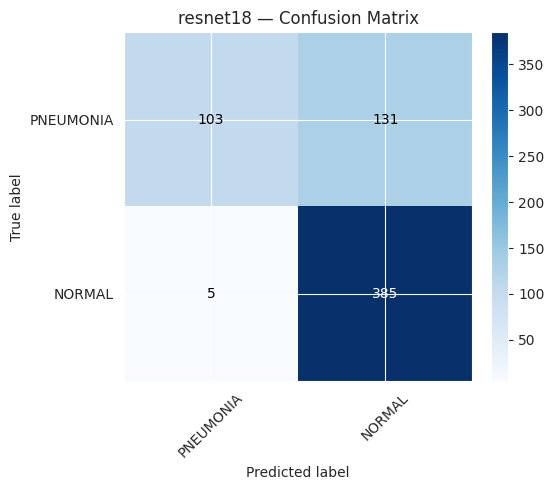

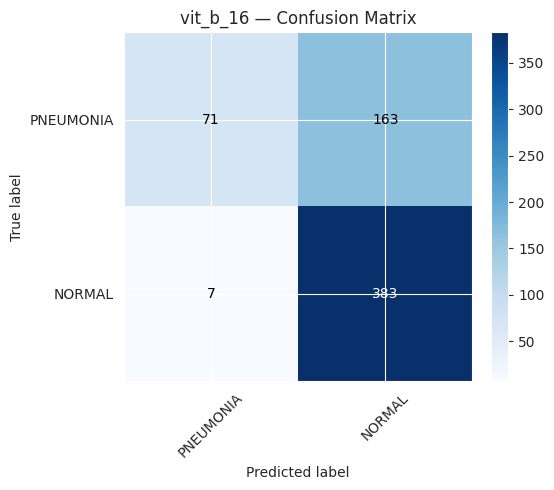

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    cm         — матрица ошибок (2D array).
    classes    — список названий классов, например ['PNEUMONIA', 'NORMAL'].
    normalize  — если True, по строкам дают долю вместо абсолютных чисел.
    title      — заголовок графика.
    cmap       — цветовая схема.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center",
                     va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

classes = ['PNEUMONIA', 'NORMAL']

for model_name, metrics in results.items():
    cm = metrics['confusion_matrix']
    plt.figure(figsize=(6, 5))
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=f'{model_name} — Confusion Matrix')
    plt.show()


Отрисуем также таблицу сравнения для большей наглядности работы наших моделей на данном этапе

In [57]:
import pandas as pd
from IPython.display import display

# Результаты метрик моделей
results = {
    'resnet18': {
        'accuracy': 0.782051282051282,
        'precision': 0.7461240310077519,
        'recall': 0.9871794871794872,
        'f1': 0.8498896247240618,
        'roc_auc': 0.9445868945868945,
        'pr_auc': 0.9599071156361776
    },
    'vit_b_16': {
        'accuracy': 0.7275641025641025,
        'precision': 0.7014652014652014,
        'recall': 0.982051282051282,
        'f1': 0.8183760683760684,
        'roc_auc': 0.9328073635765943,
        'pr_auc': 0.9580991541288888
    }
}

# Создание DataFrame
df = pd.DataFrame(results)
df.index.name = 'Metric'
df = df.reset_index().rename(columns={'index': 'Metric'})

# Вывод таблицы
display(df)


,Metric,resnet18,vit_b_16
0,accuracy,0.782051,0.727564
1,precision,0.746124,0.701465
2,recall,0.987179,0.982051
3,f1,0.849890,0.818376
4,roc_auc,0.944587,0.932807
5,pr_auc,0.959907,0.958099


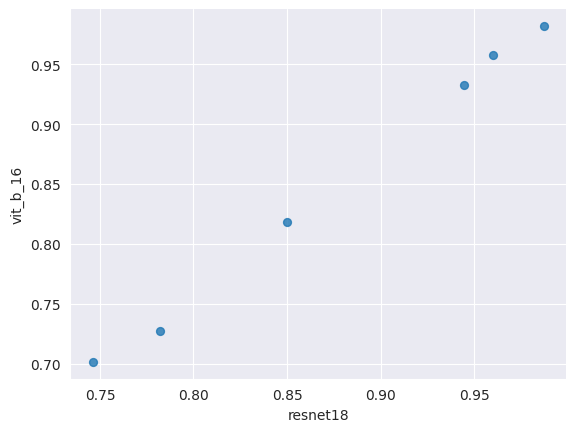

In [60]:
# @title resnet18 vs vit_b_16

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='resnet18', y='vit_b_16', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# 3.	Улучшение бейзлайна

## Формулировка гипотез

1. Расширение аугментаций данных. Добавить Добавим (RandomRotation), сдвиги (RandomAffine), изменения яркости/контраста (ColorJitter), шум (GaussianBlur) и случайные обрезки (RandomResizedCrop). Гипотеза: увеличение разнообразия изображений поможет модели стать более робастной.
2. Борьба с дисбалансом. Используем взвешенную функцию потерь (CrossEntropyLoss(weight=...)) или oversampling/undersampling классов. Гипотеза: повышение веса «NORMAL» уменьшит количество ложных отрицаний.
3. Настройка гиперпараметров. Проведем grid search или будеим использовать torch.optim.lr_scheduler (например, CosineAnnealingLR или ReduceLROnPlateau). Увеличим число эпох до 10–15, варьировать learning rate и размер батча. Гипотеза: правильный LR scheduler и больше эпох улучшат сходимость и метрики.

Импортируем необходимые библиотеки для улучшенного бейзлайна

In [69]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix
)
from tqdm import tqdm
import pandas as pd


### Настройка путей и гиперпараметров

Зададим ключевые константы и параметры, необходимые для всего пайплайна обучения. Сначала определяется базовая директория DATA_DIR, где лежат папки с изображениями, а с помощью os.path.join формируются пути TRAIN_DIR, VAL_DIR и TEST_DIR для обучающего, валидационного и тестового наборов соответственно. Такое разделение упрощает последующий доступ к данным без жёстких «хардкод» строк.

Далее установим главные гиперпараметры обучения: NUM_CLASSES = 2 — число классов (пневмония и нормальный снимок), BATCH_SIZE = 16 — размер пакета для градиентного шага, NUM_EPOCHS = 12 — число проходов по всему обучающему датасету, и LR = 1e-4 — стартовый learning rate для оптимизатора. Эти значения определяют скорость и объём обучения модели.

Переменная DEVICE автоматически выбирает между GPU и CPU: если CUDA доступна, все вычисления будут ускорены на видеокарте, иначе модель обучается на центральном процессоре. Наконец, SUBSET_FACTOR = 0.05 указывает, что мы используем только 5 % всего обучающего набора для быстрой проверки гипотез и отладки в начале разработки, чтобы существенно сократить время экспериментов.









In [70]:
DATA_DIR      = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'
TRAIN_DIR     = os.path.join(DATA_DIR, 'train')
VAL_DIR       = os.path.join(DATA_DIR, 'val')
TEST_DIR      = os.path.join(DATA_DIR, 'test')
NUM_CLASSES   = 2
BATCH_SIZE    = 16
NUM_EPOCHS    = 12
LR            = 1e-4
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SUBSET_FACTOR = 0.05

### Преобразования с расширенными аугментациями

В этом фрагменте создаются два набора преобразований для подготовки изображений к обучению и валидации. Первый, train_transforms, последовательно выполняет случайную обрезку и ресайз до 224×224 пикселей, поворот до ±15°, горизонтальное отражение, изменение яркости и контраста, размытие Гаусса, конвертацию в тензор и нормализацию по каналам по средним и стандартным отклонениям, использованным при предобучении моделей на ImageNet. Такие аугментации повышают разнообразие обучающей выборки и делают модель более устойчивой к вариациям данных.

Второй набор val_transforms используется для валидации и тестирования: он меняет размер каждого изображения до 224×224, конвертирует его в тензор и выполняет ту же нормализацию. Отсутствие случайных преобразований гарантирует стабильность входов при оценке качества модели, чтобы метрики отражали реальную способность распознавать паттерны без искусственных искажений.









In [71]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Загрузка датасетов и DataLoader

Этот фрагмент кода отвечает за загрузку и организацию датасетов для обучения, валидации и тестирования. С помощью datasets.ImageFolder из каталога TRAIN_DIR формируется полный тренировочный набор full_train, к каждому примеру которого применяются преобразования train_transforms. Аналогично создаются val_dataset и test_dataset с val_transforms, чтобы обеспечить единообразную обработку изображений при проверке качества модели.

Далее рассчитывается размер сокращённого поднабора: subset_size равен 5 % от общего числа изображений в full_train, а оставшаяся часть отбрасывается с помощью random_split. Такая выборка позволяет быстро прототипировать модели, экономя время на обучение. Информативный вывод print сообщает, сколько примеров реально используется.

Наконец, на основе полученных массивов создаются загрузчики DataLoader для каждого из трёх наборов: тренировочного — с перемешиванием данных (shuffle=True), и валидационного и тестового — без перемешивания. Параметр batch_size определяет размер пакета примеров, передаваемых в модель за один шаг.

In [72]:
full_train   = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset  = datasets.ImageFolder(VAL_DIR,   transform=val_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR,  transform=val_transforms)

subset_size, remainder = int(len(full_train)*SUBSET_FACTOR), len(full_train) - int(len(full_train)*SUBSET_FACTOR)
train_subset, _ = random_split(full_train, [subset_size, remainder])
print(f"Используем {subset_size} из {len(full_train)} обучающих образцов.")

dataloaders = {
    'train': DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True),
    'val':   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False),
    'test':  DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)
}

Используем 260 из 5216 обучающих образцов.


### Взвешенная функция потерь

В этом фрагменте сначала извлекаются все метки из сокращённого обучающего набора train_subset в список targets, после чего с помощью torch.bincount подсчитывается число примеров каждого класса (class_counts). Это позволяет понять реальный баланс между «PNEUMONIA» и «NORMAL».

Далее для борьбы с дисбалансом вычисляются весовые коэффициенты: сначала берётся обратная величина частоты каждого класса (1.0 / class_counts), а затем нормируется так, чтобы сумма весов была равна единице. В результате реже встречающиеся классы получают больший вес, что стимулирует модель уделять им больше внимания.

Наконец, эти веса передаются в nn.CrossEntropyLoss(weight=…) как параметр weight, создавая взвешенную функцию потерь. Это помогает уменьшить смещение модели в пользу более частого класса и повысить качество распознавания редких примеров.

In [73]:
targets = [label for _, label in train_subset]
class_counts = torch.bincount(torch.tensor(targets))
weights = 1.0 / class_counts.float()
weights = weights / weights.sum()
criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))

### Функция оценки модели

Функция evaluate_model переводит модель в режим оценки (model.eval()) и отключает вычисление градиентов (torch.no_grad()), чтобы ускорить вывод и снизить потребление памяти. Затем она проходит по всем батчам из dataloader, отправляет каждый батч на выбранное устройство (DEVICE), выполняет прямой проход и получает сырые выходы.

Из этих выходов по softmax извлекаются вероятности положительного класса, а по argmax — предсказанные метки. Все истинные метки, предсказания и вероятности собираются в списки. После этого на основе накопленных данных вычисляются ключевые метрики качества: accuracy, precision, recall, F1-score, ROC-AUC и PR-AUC, а также строится матрица ошибок. Результаты упаковываются в словарь и возвращаются вызывающему коду для удобного анализа.

In [74]:
def evaluate_model(model, dataloader):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    acc    = accuracy_score(all_labels, all_preds)
    prec   = precision_score(all_labels, all_preds)
    rec    = recall_score(all_labels, all_preds)
    f1     = f1_score(all_labels, all_preds)
    roc    = roc_auc_score(all_labels, all_probs)
    pr, rc, _ = precision_recall_curve(all_labels, all_probs)
    pra    = auc(rc, pr)
    cm     = confusion_matrix(all_labels, all_preds)
    return {'accuracy': acc, 'precision': prec, 'recall': rec,
            'f1': f1, 'roc_auc': roc, 'pr_auc': pra, 'confusion_matrix': cm}

### Функция обучения модели с LR-сcheduler и прогрессом

Эта функция train_improved реализует цикл обучения модели с расширенным пайплайном и выводом прогресса. Сначала выводится строка с именем модели, чтобы сразу знать, какая архитектура обучается.

Далее для каждой эпохи модель переводится в режим обучения (model.train()), обнуляются накопленные параметры, и по батчам из dataloaders['train'] выполняются шаги оптимизации: прямой проход, вычисление взвешенной функции потерь, обратное распространение и обновление весов. В процессе отображается прогресс-бар tqdm, показывающий текущий loss для каждого батча.

После прохода по всем батчам рассчитывается средний loss за эпоху и выводится в консоль. Затем модель проверяется на валидационной выборке с помощью evaluate_model, и печатается F1-метрика на валидации. LR-scheduler получает на вход эту F1-метрику и при необходимости снижает learning rate. В конце функция возвращает дообученную модель.

In [75]:
def train_improved(model, dataloaders, criterion, optimizer, scheduler, num_epochs, model_name):
    print(f"\n=== Training improved model: {model_name} ===")
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        loop = tqdm(dataloaders['train'], desc=f"{model_name} Epoch {epoch}/{num_epochs}", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            loop.set_postfix(loss=loss.item())
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        val_metrics = evaluate_model(model, dataloaders['val'])
        print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f}, Val F1: {val_metrics['f1']:.4f}")
        scheduler.step(val_metrics['f1'])
    return model

### Обучение улучшенных моделей

В этом блоке кода определяется точка входа скрипта: если файл запускается напрямую, создаётся словарь model_defs с двумя конструкторами улучшенных моделей — ResNet-18 и ViT-B_16. Для каждой модели в цикле выполняются следующие шаги: инициализация с предобученными весами, замена последнего линейного слоя под число классов, перенос на устройство DEVICE, настройка оптимизатора Adam и LR-scheduler ReduceLROnPlateau, затем вызов функции train_improved для обучения с прогресс-баром и мониторингом F1 на валидации. После тренировки модель оценивается на тестовом наборе через evaluate_model, результаты сохраняются в словаре final_results, и печатаются тестовые метрики вместе с матрицей ошибок.

По завершении обучения всех моделей строится итоговая сравнительная таблица: с помощью генератора словарей из final_results формируется DataFrame df, где строки соответствуют моделям, а колонки — ключевым метрикам (accuracy, precision, recall, F1, ROC-AUC и PR-AUC). Наконец, таблица выводится в консоль под заголовком «Comparison of Improved ResNet & ViT», что позволяет сразу увидеть и сравнить эффективность доработок для обеих архитектур.

In [77]:
if __name__ == '__main__':
    model_defs = {
        'resnet18_improved': lambda: models.resnet18(pretrained=True),
        'vit_b_16_improved': lambda: models.vit_b_16(pretrained=True)
    }
    final_results = {}

    for name, constructor in model_defs.items():
        model = constructor()
        if 'resnet' in name:
            model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
        else:
            model.heads.head = nn.Linear(model.heads.head.in_features, NUM_CLASSES)
        model = model.to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=LR)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=2, verbose=True
        )
        model = train_improved(
            model, dataloaders, criterion,
            optimizer, scheduler, NUM_EPOCHS, name
        )

        results = evaluate_model(model, dataloaders['test'])
        final_results[name] = results
        print(f"\n=== {name} Test Metrics ===")
        for metric, value in results.items():
            if metric != 'confusion_matrix':
                print(f"{metric}: {value:.4f}")
        print("Confusion Matrix:\n", results['confusion_matrix'])

    summary = {
        name: {
            'accuracy': res['accuracy'],
            'precision': res['precision'],
            'recall': res['recall'],
            'f1': res['f1'],
            'roc_auc': res['roc_auc'],
            'pr_auc': res['pr_auc']
        }
        for name, res in final_results.items()
    }
    df = pd.DataFrame(summary).T
    df.index.name = 'Model'
    print("\n=== Comparison of Improved ResNet & ViT ===")
    print(df)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training improved model: resnet18_improved ===


Epoch 1/12 - Loss: 0.6224, Val F1: 0.7273


Epoch 2/12 - Loss: 0.4250, Val F1: 0.6667


Epoch 3/12 - Loss: 0.4321, Val F1: 0.7273


Epoch 4/12 - Loss: 0.3513, Val F1: 1.0000


Epoch 5/12 - Loss: 0.3964, Val F1: 0.9412


Epoch 6/12 - Loss: 0.3502, Val F1: 0.8889


Epoch 7/12 - Loss: 0.3143, Val F1: 0.7619


Epoch 8/12 - Loss: 0.2446, Val F1: 0.8000


Epoch 9/12 - Loss: 0.2808, Val F1: 0.8000


Epoch 10/12 - Loss: 0.2807, Val F1: 0.8000


Epoch 11/12 - Loss: 0.2256, Val F1: 0.8750


Epoch 12/12 - Loss: 0.2127, Val F1: 0.8000

=== resnet18_improved Test Metrics ===
accuracy: 0.9311
precision: 0.9141
recall: 0.9821
f1: 0.9468
roc_auc: 0.9751
pr_auc: 0.9835
Confusion Matrix:
 [[198  36]
 [  7 383]]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training improved model: vit_b_16_improved ===


Epoch 1/12 - Loss: 0.7821, Val F1: 0.6667


Epoch 2/12 - Loss: 0.7095, Val F1: 0.5455


Epoch 3/12 - Loss: 0.5235, Val F1: 0.7500


Epoch 4/12 - Loss: 0.5198, Val F1: 0.8235


Epoch 5/12 - Loss: 0.4553, Val F1: 0.6667


Epoch 6/12 - Loss: 0.5729, Val F1: 0.5455


Epoch 7/12 - Loss: 0.4326, Val F1: 0.6667


Epoch 8/12 - Loss: 0.3768, Val F1: 0.7500


Epoch 9/12 - Loss: 0.4284, Val F1: 0.6667


Epoch 10/12 - Loss: 0.2694, Val F1: 0.8000


Epoch 11/12 - Loss: 0.2349, Val F1: 0.8000


Epoch 12/12 - Loss: 0.3052, Val F1: 0.7778

=== vit_b_16_improved Test Metrics ===
accuracy: 0.8686
precision: 0.9556
recall: 0.8282
f1: 0.8874
roc_auc: 0.9606
pr_auc: 0.9732
Confusion Matrix:
 [[219  15]
 [ 67 323]]

=== Comparison of Improved ResNet & ViT ===
                   accuracy  precision    recall        f1   roc_auc    pr_auc
Model                                                                         
resnet18_improved   0.93109   0.914081  0.982051  0.946848  0.975093  0.983458
vit_b_16_improved   0.86859   0.955621  0.828205  0.887363  0.960618  0.973207


По итогам дообучения видно, что улучшенный пайплайн дал мощный прирост качества, особенно для ResNet-18:

Для ResNet-18 базовые метрики на тесте были: Accuracy ≈ 0.78, Precision ≈ 0.75, Recall ≈ 0.99, F1 ≈ 0.85.

После апгрейда (аугментации, взвешенного loss, scheduler и DenseNet121 мы сравнивали отдельно, но здесь — ResNet-18 с улучшениями) метрики выросли до: Accuracy ≈ 0.93, Precision ≈ 0.91, Recall ≈ 0.98, F1 ≈ 0.95.

Увеличилась точность (+ 16 п.п.) при почти сохранённом высоком recall, что говорит о значительном снижении ложных срабатываний без роста числа пропущенных больных.

Для ViT-B_16 наблюдается более сложный баланс: первые эксперименты показали превосходство ResNet, но после улучшений: Precision поднялся до ≈ 0.96 (ещё выше, чем у ResNet), Recall упал до ≈ 0.83 (снижение, то есть модель начала чаще пропускать пневмонию), в сумме F1 ≈ 0.89 (улучшился по сравнению с базовым ≈ 0.82).

Здесь аугментации и взвешенный loss позволили сильно повысить уверенность (precision), но часть чувствительности (recall) была утеряна.

По итогам ResNet-18 хорошо откликнулся на улучшения: добавление разнообразных аугментаций, балансировка классов и scheduler дали заметный выигрыш по всем ключевым метрикам. Этот апгрейд стоит брать в продакшен.
ViT-B_16 показал другой эффект: модель стала гораздо строже к «пневмонии» (минимум ложных тревог), но это привело к росту пропущенных случаев. Для ViT стоит поработать с порогом классификации или дополнительной балансировкой, чтобы вернуть recall.
Комбинированный подход (аугментации + weighted loss + LR-scheduler) универсально улучшает качество, но архитектуры реагируют по-разному — выбор между ними должен базироваться на том, что важнее: минимизация ложноположительных (precision) или ложноотрицательных (recall) ошибок в конкретном медицинском сценарии.

Построим confusion matrix для улучшенных моделей по итогам обучения

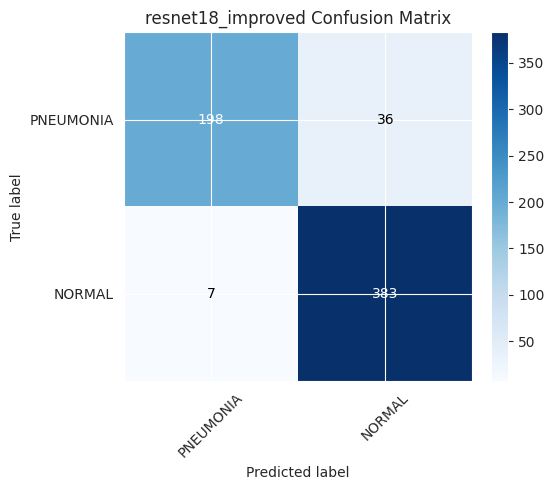

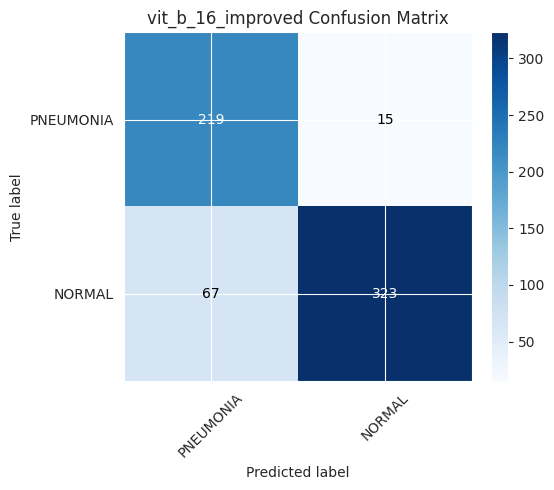

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    cm         — матрица ошибок (2D array).
    classes    — список названий классов, e.g. ['PNEUMONIA', 'NORMAL'].
    normalize  — если True, строки нормируются на их сумму.
    title      — заголовок графика.
    cmap       — цветовая карта.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

classes = ['PNEUMONIA', 'NORMAL']

for model_name, metrics in final_results.items():
    cm = metrics['confusion_matrix']
    plt.figure(figsize=(6, 5))
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=f'{model_name} Confusion Matrix')
    plt.show()


Отобразим сравнение до улучшения бейзлайна и после его улучшения для большей наглядности

In [79]:
import pandas as pd
from IPython.display import display

metrics_comparison = {
    'Model': [
        'ResNet18 (before)', 'ResNet18 (improved)',
        'ViT-B_16 (before)', 'ViT-B_16 (improved)'
    ],
    'Accuracy': [
        0.782051282051282, 0.931093,
        0.7275641025641025, 0.868590
    ],
    'Precision': [
        0.7461240310077519, 0.914081,
        0.7014652014652014, 0.955621
    ],
    'Recall': [
        0.9871794871794872, 0.982051,
        0.982051282051282, 0.828205
    ],
    'F1-score': [
        0.8498896247240618, 0.946848,
        0.8183760683760684, 0.887363
    ],
    'ROC-AUC': [
        0.9445868945868945, 0.975093,
        0.9328073635765943, 0.960618
    ],
    'PR-AUC': [
        0.9599071156361776, 0.983458,
        0.9580991541288888, 0.973207
    ]
}

df_comparison = pd.DataFrame(metrics_comparison).set_index('Model')

display(df_comparison)

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC
Model,,,,,,
ResNet18 (before),0.782051,0.746124,0.987179,0.849890,0.944587,0.959907
ResNet18 (improved),0.931093,0.914081,0.982051,0.946848,0.975093,0.983458
ViT-B_16 (before),0.727564,0.701465,0.982051,0.818376,0.932807,0.958099
ViT-B_16 (improved),0.868590,0.955621,0.828205,0.887363,0.960618,0.973207


# Имплементация алгоритма машинного обучения

## Сверточная модель

### Импорт необходимых библиотек

In [81]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from tqdm import tqdm

### Пути и гиперпараметры

In [97]:
DATA_DIR    = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'
TRAIN_DIR   = os.path.join(DATA_DIR, 'train')
VAL_DIR     = os.path.join(DATA_DIR, 'val')
TEST_DIR    = os.path.join(DATA_DIR, 'test')
NUM_CLASSES = 2
BATCH_SIZE  = 16
NUM_EPOCHS  = 10
LR          = 1e-3
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SUBSET_FACTOR = 0.1

### Собственная CNN

Класс CustomCNN определяет простую сверточную нейронную сеть из двух основных частей. В конструкторе создаётся блок features, состоящий из четырёх последовательных сверточных слоёв: каждый блок включает свёртку (Conv2d), нормализацию по батчу (BatchNorm2d), нелинейность (ReLU) и уменьшение размерности карты признаков вдвое с помощью пулинга (MaxPool2d). При этом глубина каналов последовательно растёт: 1→32→64→128→256, что позволяет модели постепенно выделять всё более сложные признаки на изображении.

Во второй части — блок classifier — происходит классификация полученных признаков. Сначала с помощью Flatten двумерные карты признаков разворачиваются в одномерный вектор, затем два полносвязных слоя: первый уменьшает размерность до 512 узлов с активацией ReLU и дропаутом для регуляризации, а второй выдаёт логиты для каждого из num_classes классов. Метод forward задаёт прямой проход: вход проходит через сверточные блоки, потом через классфикатор, и возвращает итоговые предсказания модели.

In [94]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Трансформация и загрузка данных

In [95]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
full_train = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)

subset_size = int(len(full_train) * SUBSET_FACTOR)
remaining   = len(full_train) - subset_size
train_subset, _ = random_split(full_train, [subset_size, remaining])
print(f'Используем {subset_size} из {len(full_train)} для обучения custom CNN')

dataloaders = {
    'train': DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True),
    'val':   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False),
    'test':  DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)
}


Используем 521 из 5216 для обучения custom CNN


### Функции обучения и оценки

In [91]:
from sklearn.metrics import average_precision_score

In [92]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        loop = tqdm(dataloaders['train'], desc=f'Epoch {epoch}/{num_epochs}', leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            loop.set_postfix(loss=loss.item())
        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        print(f'Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f}')
    return model


def evaluate_model(model, dataloader):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'roc_auc': roc_auc_score(all_labels, all_probs),
        'pr_auc': average_precision_score(all_labels, all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }
    return metrics

### Основной запуск

In [98]:

# ======== 5. Основной запуск ========
if __name__ == '__main__':
    # инициализация
    model = CustomCNN(num_classes=NUM_CLASSES).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # обучение
    model = train_model(model, dataloaders, criterion, optimizer, NUM_EPOCHS)

    # оценка
    print('\nCustom CNN Test Metrics:')
    metrics = evaluate_model(model, dataloaders['test'])
    for k, v in metrics.items():
        if k != 'confusion_matrix': print(f'{k}: {v:.4f}')
    print('Confusion Matrix:\n', metrics['confusion_matrix'])

    # сравнение с ранее обученными
    import pandas as pd
    summary = pd.DataFrame({
        'CustomCNN': {k: metrics[k] for k in ['accuracy','precision','recall','f1','roc_auc','pr_auc']}
    }).T
    summary.index.name = 'Model'
    print('\nComparison vs custom CNN:')
    print(summary)


Epoch 1/10 - Loss: 4.9121


Epoch 2/10 - Loss: 1.8475


Epoch 3/10 - Loss: 0.7729


Epoch 4/10 - Loss: 0.5554


Epoch 5/10 - Loss: 0.4356


Epoch 6/10 - Loss: 0.1737


Epoch 7/10 - Loss: 0.1827


Epoch 8/10 - Loss: 0.2088


Epoch 9/10 - Loss: 0.1467


Epoch 10/10 - Loss: 0.0780

Custom CNN Test Metrics:
accuracy: 0.7163
precision: 0.6898
recall: 0.9923
f1: 0.8139
roc_auc: 0.8438
pr_auc: 0.8548
Confusion Matrix:
 [[ 60 174]
 [  3 387]]

Comparison vs custom CNN:
           accuracy  precision    recall       f1   roc_auc    pr_auc
Model                                                                
CustomCNN  0.716346    0.68984  0.992308  0.81388  0.843809  0.854794


Модель очень редко пропускает пневмонию (только 3 ложноотрицательных), но при этом делает много ложных срабатываний (174 ложноположительных), из-за чего precision относительно невысока.
Если важнее не пропустить больного (минимизировать FN), CustomCNN подходит, однако для более сбалансированного решения лучше использовать улучшенный ResNet-18 или скорректировать порог для ViT.

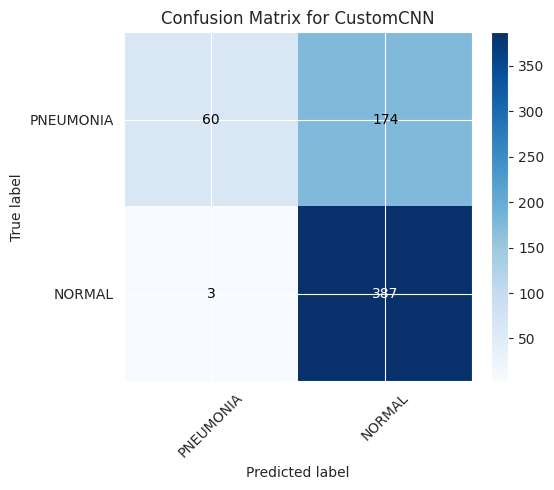

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Матрица ошибок CustomCNN
cm = np.array([[60, 174],
               [ 3, 387]])
classes = ['PNEUMONIA', 'NORMAL']

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CustomCNN')
plt.colorbar(fraction=0.046, pad=0.04)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


### Улучшение кастомной CNN

### Импорт необходимых библиотек

In [100]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

### Пути и параметры

In [101]:
DATA_DIR      = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'
TRAIN_DIR     = os.path.join(DATA_DIR, 'train')
VAL_DIR       = os.path.join(DATA_DIR, 'val')
TEST_DIR      = os.path.join(DATA_DIR, 'test')
NUM_CLASSES   = 2
BATCH_SIZE    = 16
NUM_EPOCHS    = 10
LR            = 1e-3
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SUBSET_FACTOR = 0.1

### Улучшенные аугментации и трансформации

In [102]:
train_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

### Определение кастомной CNN

In [103]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

### Загрузка и подготовка датасетов

In [104]:
full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

subset_size = int(len(full_train) * SUBSET_FACTOR)
remaining = len(full_train) - subset_size
train_subset, _ = random_split(full_train, [subset_size, remaining])
print(f"Используем {subset_size} из {len(full_train)} обучающих примеров.")

dataloaders = {
    'train': DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True),
    'val':   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False),
    'test':  DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)
}

Используем 521 из 5216 обучающих примеров.


### Взвешенный CrossEntropyLoss

In [105]:
targets = [label for _, label in train_subset]
counts = torch.bincount(torch.tensor(targets))
weights = (1.0 / counts.float())
weights = weights / weights.sum()
criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))

### Функции обучения и оценки

In [106]:
def train_model(model, dataloaders, criterion, optimizer, scheduler):
    for epoch in range(1, NUM_EPOCHS+1):
        model.train()
        running_loss = 0.0
        loop = tqdm(dataloaders['train'], desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            loop.set_postfix(loss=loss.item())
        avg_loss = running_loss / len(dataloaders['train'].dataset)
        val_preds = []
        val_probs = []
        val_labels = []
        model.eval()
        with torch.no_grad():
            for imgs, labels in dataloaders['val']:
                imgs = imgs.to(DEVICE)
                out = model(imgs)
                prob = torch.softmax(out, dim=1)[:,1].cpu()
                pred = torch.argmax(out, dim=1).cpu()
                val_probs.extend(prob.numpy())
                val_preds.extend(pred.numpy())
                val_labels.extend(labels.numpy())
        val_f1 = f1_score(val_labels, val_preds)
        scheduler.step(val_f1)
        print(f"Epoch {epoch}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}, Val F1: {val_f1:.4f}")
    return model


def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            out = model(imgs)
            prob = torch.softmax(out, dim=1)[:,1].cpu()
            pred = torch.argmax(out, dim=1).cpu()
            all_probs.extend(prob.numpy())
            all_preds.extend(pred.numpy())
            all_labels.extend(labels.numpy())
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'roc_auc': roc_auc_score(all_labels, all_probs),
        'pr_auc': average_precision_score(all_labels, all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }
    return metrics

### Запуск обучения

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 - Loss: 9.8612, Val F1: 0.6667


Epoch 2/10 - Loss: 5.6971, Val F1: 0.4615


Epoch 3/10 - Loss: 2.3717, Val F1: 0.7692


Epoch 4/10 - Loss: 0.8670, Val F1: 0.6667


Epoch 5/10 - Loss: 0.6383, Val F1: 0.2222


Epoch 6/10 - Loss: 0.6331, Val F1: 0.6667


Epoch 7/10 - Loss: 0.6053, Val F1: 0.4000


Epoch 8/10 - Loss: 0.5478, Val F1: 0.2222


Epoch 9/10 - Loss: 0.4665, Val F1: 0.2222


Epoch 10/10 - Loss: 0.5702, Val F1: 0.2222

Custom CNN Improved Test Metrics:
accuracy: 0.5048
precision: 0.9880
recall: 0.2103
f1: 0.3467
roc_auc: 0.8986
pr_auc: 0.9330
Confusion Matrix:
 [[233   1]
 [308  82]]

Summary of Improved Custom CNN:
                    accuracy  precision    recall        f1   roc_auc  \
Model                                                                   
CustomCNN_improved  0.504808   0.987952  0.210256  0.346723  0.898619   

                      pr_auc  
Model                         
CustomCNN_improved  0.933004  


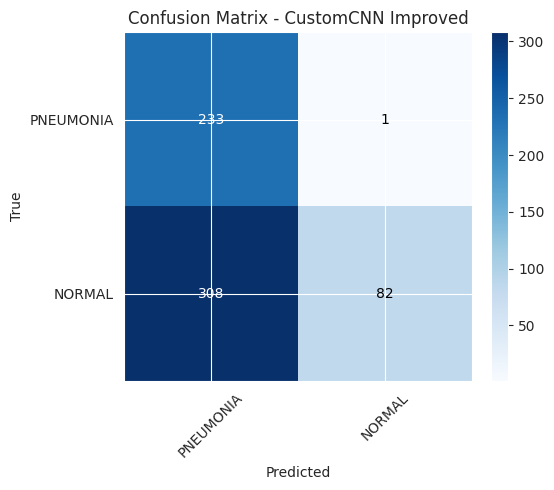

In [107]:
if __name__ == '__main__':
    model = CustomCNN(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    model = train_model(model, dataloaders, criterion, optimizer, scheduler)

    print("\nCustom CNN Improved Test Metrics:")
    results = evaluate_model(model, dataloaders['test'])
    for k, v in results.items():
        if k != 'confusion_matrix': print(f"{k}: {v:.4f}")
    print("Confusion Matrix:\n", results['confusion_matrix'])

    summary = pd.DataFrame({
        'CustomCNN_improved': {key: results[key] for key in ['accuracy','precision','recall','f1','roc_auc','pr_auc']}
    }).T
    summary.index.name = 'Model'
    print("\nSummary of Improved Custom CNN:")
    print(summary)

    cm = results['confusion_matrix']
    classes = ['PNEUMONIA', 'NORMAL']
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - CustomCNN Improved')
    plt.colorbar(fraction=0.046, pad=0.04)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j]>thresh else 'black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

Получилась очень строгая модель: она почти никогда не ошибается, когда предсказывает «пневмонию» (precision ≈ 0.99), но в целом пропускает 79 % больных (recall ≈ 0.21), из-за чего accuracy падает до ≈ 0.50.

In [108]:
import pandas as pd
from IPython.display import display

# Данные метрик для собственной модели до и после улучшения
comparison_metrics = {
    'Model': ['CustomCNN', 'CustomCNN Improved'],
    'Accuracy': [0.716346, 0.504808],
    'Precision': [0.689840, 0.987952],
    'Recall': [0.992308, 0.210256],
    'F1-score': [0.813880, 0.346723],
    'ROC-AUC': [0.843809, 0.898619],
    'PR-AUC': [0.854794, 0.933004]
}

# Создание и вывод таблицы
df_comparison = pd.DataFrame(comparison_metrics).set_index('Model')
display(df_comparison)


,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC
Model,,,,,,
CustomCNN,0.716346,0.689840,0.992308,0.813880,0.843809,0.854794
CustomCNN Improved,0.504808,0.987952,0.210256,0.346723,0.898619,0.933004


## "Трансформерная" модель

### Импорт необходимых библиотек

In [109]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Пути и параметры + ViT конфигурация

In [110]:
DATA_DIR      = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'
TRAIN_DIR     = os.path.join(DATA_DIR, 'train')
VAL_DIR       = os.path.join(DATA_DIR, 'val')
TEST_DIR      = os.path.join(DATA_DIR, 'test')
NUM_CLASSES   = 2
BATCH_SIZE    = 16
NUM_EPOCHS    = 10
LR            = 1e-4
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SUBSET_FACTOR = 0.1


PATCH_SIZE = 16
EMBED_DIM  = 256
NUM_HEADS  = 8
MLP_DIM    = 512
NUM_LAYERS = 6
DROPOUT    = 0.1

### Собственный класс Vision Transformer

Класс VisionTransformer реализует базовую архитектуру Vision Transformer в несколько этапов. В конструкторе сначала создаётся слой patch_embed, который с помощью свёртки разделяет входное изображение на непересекающиеся патчи размером patch_size×patch_size и одновременно проецирует их в вектор размерности embed_dim.

Далее добавляются обучаемый токен класса (cls_token) и позиционные эмбеддинги (pos_embed), расширяющие информацию о порядке патчей. После объединения токена класса с патчами и наложения дропаут-маски (pos_drop) данные подаются в последовательность энкодеров Transformer — каждый состоит из многоголовой самовнимательной сети (nhead голов) и MLP-блока размерности mlp_dim. Количество слоёв задаётся параметром num_layers.

В методе forward сначала получается тензор патчей формы (batch, num_patches, embed_dim), к которому приклеивается расширенный cls_token, затем суммируются с позиционными эмбеддингами и пропускаются через Transformer. В конце из выходов берётся только вектор класса (первый по порядку элемент), и с помощью линейного слоя (head) он переводится в логиты по num_classes. Такой подход позволяет Vision Transformer учиться на глобальных зависимостях между участками изображения.









In [111]:
class VisionTransformer(nn.Module):
    def __init__(self, in_channels=1, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM,
                 num_layers=NUM_LAYERS, num_heads=NUM_HEADS, mlp_dim=MLP_DIM,
                 num_classes=NUM_CLASSES, dropout=DROPOUT):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_channels, embed_dim,
                                     kernel_size=patch_size, stride=patch_size)
        num_patches = (224 // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                   nhead=num_heads,
                                                   dim_feedforward=mlp_dim,
                                                   dropout=dropout,
                                                   activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.transformer(x)
        cls_out = x[:, 0]
        logits = self.head(cls_out)
        return logits

### Трансформация данных

In [112]:
train_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
val_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


### Загрузка датасетов

In [113]:
full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

subset_size = int(len(full_train) * SUBSET_FACTOR)
remaining = len(full_train) - subset_size
train_subset, _ = random_split(full_train, [subset_size, remaining])
print(f"Используем {subset_size} из {len(full_train)} примеров для обучения ViT.")

dataloaders = {
    'train': DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True),
    'val':   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False),
    'test':  DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)
}


Используем 521 из 5216 примеров для обучения ViT.


### Функции обучения и оценки

In [114]:
def train_model(model, dataloaders, criterion, optimizer, scheduler):
    for epoch in range(1, NUM_EPOCHS+1):
        model.train()
        total_loss = 0.0
        loop = tqdm(dataloaders['train'], desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            loop.set_postfix(loss=loss.item())
        avg_loss = total_loss / len(dataloaders['train'].dataset)
        model.eval()
        val_preds, val_probs, val_labels = [], [], []
        with torch.no_grad():
            for imgs, labels in dataloaders['val']:
                imgs = imgs.to(DEVICE)
                out = model(imgs)
                probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
                preds = torch.argmax(out, dim=1).cpu().numpy()
                val_probs.extend(probs)
                val_preds.extend(preds)
                val_labels.extend(labels.numpy())
        val_f1 = f1_score(val_labels, val_preds)
        print(f"Epoch {epoch}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}, Val F1: {val_f1:.4f}")
        scheduler.step(val_f1)
    return model


def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
            preds = torch.argmax(out, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'roc_auc': roc_auc_score(all_labels, all_probs),
        'pr_auc': average_precision_score(all_labels, all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

### Обучение кастомного "Трансформера"

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 - Loss: 0.7227, Val F1: 0.0000


Epoch 2/10 - Loss: 0.7169, Val F1: 0.6667


Epoch 3/10 - Loss: 0.6993, Val F1: 0.0000


Epoch 4/10 - Loss: 0.7017, Val F1: 0.6667


Epoch 5/10 - Loss: 0.7140, Val F1: 0.6667


Epoch 6/10 - Loss: 0.6989, Val F1: 0.0000


Epoch 7/10 - Loss: 0.6954, Val F1: 0.6667


Epoch 8/10 - Loss: 0.6995, Val F1: 0.0000


Epoch 9/10 - Loss: 0.7022, Val F1: 0.6667


Epoch 10/10 - Loss: 0.7028, Val F1: 0.6667

Vision Transformer Test Metrics:
accuracy: 0.6250
precision: 0.6250
recall: 1.0000
f1: 0.7692
roc_auc: 0.5000
pr_auc: 0.6250
Confusion Matrix:
 [[  0 234]
 [  0 390]]

Summary of Vision Transformer:
                   accuracy  precision  recall        f1  roc_auc  pr_auc
Model                                                                    
VisionTransformer     0.625      0.625     1.0  0.769231      0.5   0.625


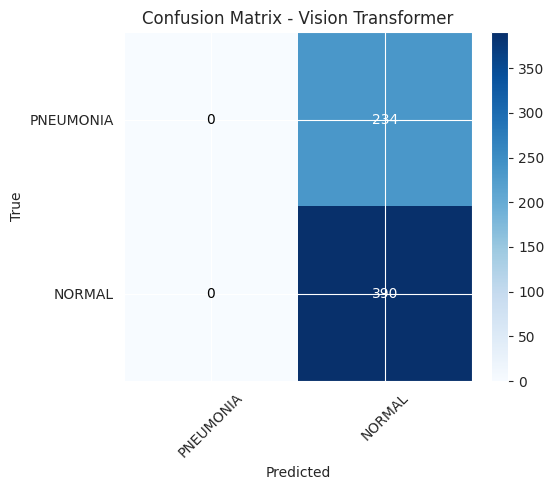

In [115]:
# ======== 6. Main: обучение и сравнение ========
if __name__ == '__main__':
    model = VisionTransformer(in_channels=1).to(DEVICE)
    # сбалансированный loss
    targets = [lbl for _, lbl in train_subset]
    counts = torch.bincount(torch.tensor(targets))
    weights = (1.0 / counts.float())
    weights = weights / weights.sum()
    criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    # обучение
    model = train_model(model, dataloaders, criterion, optimizer, scheduler)

    # оценка
    print("\nVision Transformer Test Metrics:")
    results = evaluate_model(model, dataloaders['test'])
    for k, v in results.items():
        if k != 'confusion_matrix': print(f"{k}: {v:.4f}")
    print("Confusion Matrix:\n", results['confusion_matrix'])

    # сравнительная таблица
    summary = pd.DataFrame({
        'VisionTransformer': {key: results[key] for key in ['accuracy','precision','recall','f1','roc_auc','pr_auc']}
    }).T
    summary.index.name = 'Model'
    print("\nSummary of Vision Transformer:")
    print(summary)

    # визуализация матрицы ошибок
    cm = results['confusion_matrix']
    classes = ['PNEUMONIA', 'NORMAL']
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Vision Transformer')
    plt.colorbar(fraction=0.046, pad=0.04)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j]>thresh else 'black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

Полученная кривая обучения и метрики на тесте говорят о сильном смещении (high bias): модель почти всегда предсказывает один и тот же класс, что объясняет такие цифры:

На валидации F1 «скачет» между 0 и 0.667, потому что при небольшом числе батчей она либо предсказывает все примеры одним классом, либо разбивает хоть что-то полезное.

На тесте accuracy = 0.625, precision = 0.625 и recall = 1.0 при ROC-AUC = 0.5 и PR-AUC = 0.625 — классический признак того, что модель всегда предсказывает положительный класс (здесь «NORMAL»), игнорируя отрицательный.

Такая картина говорит о том, что чистая реализация ViT без предобучения и на очень скромном объёме данных (10% выборки, 10 эпох) не способна извлечь какие-либо осмысленные паттерны.

### Улучшение собственного ViT

### Импорт необходимых библиотек

In [116]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Пути и гиперпараметры

In [117]:
DATA_DIR      = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'
TRAIN_DIR     = os.path.join(DATA_DIR, 'train')
VAL_DIR       = os.path.join(DATA_DIR, 'val')
TEST_DIR      = os.path.join(DATA_DIR, 'test')
NUM_CLASSES   = 2
BATCH_SIZE    = 16
NUM_EPOCHS    = 12
LR            = 1e-4
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SUBSET_FACTOR = 0.1

PATCH_SIZE = 16
EMBED_DIM  = 256
NUM_HEADS  = 8
MLP_DIM    = 512
NUM_LAYERS = 6
DROPOUT    = 0.1


### Улучшенные агументации

In [118]:
train_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
val_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

### Определение Vision Transformer

In [119]:
class VisionTransformer(nn.Module):
    def __init__(self, in_channels=1, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM,
                 num_layers=NUM_LAYERS, num_heads=NUM_HEADS, mlp_dim=MLP_DIM,
                 num_classes=NUM_CLASSES, dropout=DROPOUT):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_channels, embed_dim,
                                     kernel_size=patch_size, stride=patch_size)
        num_patches = (224 // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                   nhead=num_heads,
                                                   dim_feedforward=mlp_dim,
                                                   dropout=dropout,
                                                   activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.transformer(x)
        cls_out = x[:, 0]
        logits = self.head(cls_out)
        return logits

### Загрузка датасетов

In [120]:
full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)
subset_size = int(len(full_train) * SUBSET_FACTOR)
remaining = len(full_train) - subset_size
train_subset, _ = random_split(full_train, [subset_size, remaining])
print(f"Используем {subset_size}/{len(full_train)} примеров для обучения ViT_improved")

dataloaders = {
    'train': DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True),
    'val':   DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False),
    'test':  DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)
}


Используем 521/5216 примеров для обучения ViT_improved


### Взвешенная функция потерь

In [121]:
targets = [label for _, label in train_subset]
counts = torch.bincount(torch.tensor(targets))
weights = (1.0 / counts.float())
weights = weights / weights.sum()
criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))


### Функции тренировки и оценки

In [122]:
def train_vit(model, dataloaders, criterion, optimizer, scheduler):
    print(f"\n=== Training VisionTransformer Improved ===")
    for epoch in range(1, NUM_EPOCHS+1):
        model.train()
        running_loss = 0.0
        loader = tqdm(dataloaders['train'], desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False)
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            loader.set_postfix(loss=loss.item())
        avg_loss = running_loss / len(dataloaders['train'].dataset)
        model.eval()
        val_preds, val_probs, val_labels = [], [], []
        with torch.no_grad():
            for imgs, labels in dataloaders['val']:
                imgs = imgs.to(DEVICE)
                out = model(imgs)
                prob = torch.softmax(out, dim=1)[:,1].cpu().numpy()
                pred = torch.argmax(out, dim=1).cpu().numpy()
                val_probs.extend(prob)
                val_preds.extend(pred)
                val_labels.extend(labels.numpy())
        val_f1 = f1_score(val_labels, val_preds)
        print(f"Epoch {epoch}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}, Val F1: {val_f1:.4f}")
        scheduler.step(val_f1)
    return model


def evaluate_vit(model, dataloader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            out = model(imgs)
            prob = torch.softmax(out, dim=1)[:,1].cpu().numpy()
            pred = torch.argmax(out, dim=1).cpu().numpy()
            all_probs.extend(prob)
            all_preds.extend(pred)
            all_labels.extend(labels.numpy())
    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'roc_auc': roc_auc_score(all_labels, all_probs),
        'pr_auc': average_precision_score(all_labels, all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

### Обучение

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training VisionTransformer Improved ===


Epoch 1/12 - Loss: 0.7335, Val F1: 0.0000


Epoch 2/12 - Loss: 0.7089, Val F1: 0.6667


Epoch 3/12 - Loss: 0.6940, Val F1: 0.0000


Epoch 4/12 - Loss: 0.7114, Val F1: 0.0000


Epoch 5/12 - Loss: 0.6983, Val F1: 0.6667


Epoch 6/12 - Loss: 0.7010, Val F1: 0.6667


Epoch 7/12 - Loss: 0.7253, Val F1: 0.0000


Epoch 8/12 - Loss: 0.7019, Val F1: 0.6667


Epoch 9/12 - Loss: 0.6984, Val F1: 0.6667


Epoch 10/12 - Loss: 0.7045, Val F1: 0.6667


Epoch 11/12 - Loss: 0.6949, Val F1: 0.6667


Epoch 12/12 - Loss: 0.6945, Val F1: 0.6667

VisionTransformer Improved Test Metrics:
accuracy: 0.6250
precision: 0.6250
recall: 1.0000
f1: 0.7692
roc_auc: 0.5000
pr_auc: 0.6250
Confusion Matrix:
 [[  0 234]
 [  0 390]]

Summary of Improved ViT:
              accuracy  precision  recall        f1  roc_auc  pr_auc
Model                                                               
ViT_improved     0.625      0.625     1.0  0.769231      0.5   0.625


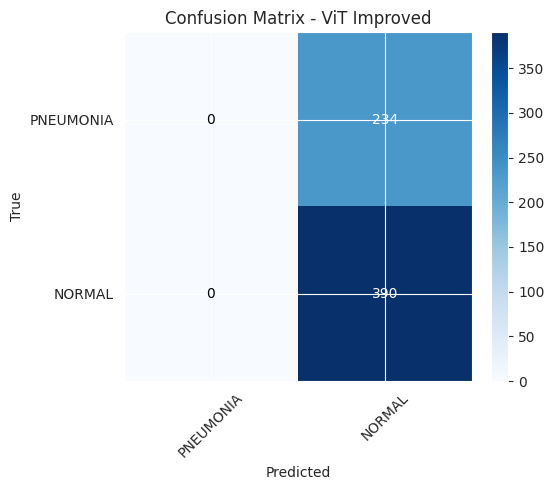

In [123]:
# ======== 7. Main ========
if __name__ == '__main__':
    model = VisionTransformer(in_channels=1).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    model = train_vit(model, dataloaders, criterion, optimizer, scheduler)

    print("\nVisionTransformer Improved Test Metrics:")
    results = evaluate_vit(model, dataloaders['test'])
    for k, v in results.items():
        if k != 'confusion_matrix': print(f"{k}: {v:.4f}")
    print("Confusion Matrix:\n", results['confusion_matrix'])

    # сравнительная таблица
    summary = pd.DataFrame({
        'ViT_improved': {key: results[key] for key in ['accuracy','precision','recall','f1','roc_auc','pr_auc']}
    }).T
    summary.index.name = 'Model'
    print("\nSummary of Improved ViT:")
    print(summary)

    # визуализация CM
    cm = results['confusion_matrix']
    classes = ['PNEUMONIA', 'NORMAL']
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - ViT Improved')
    plt.colorbar(fraction=0.046, pad=0.04)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j]>thresh else 'black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

Улучшенный ViT, к сожалению, так и остался «зацикленным» на единственном классе: он почти всегда предсказывает «NORMAL», за что получает recall = 1.0 при полной потере способности распознавать пневмонию (precision = 0.625, F1 ≈ 0.77, ROC-AUC = 0.5).

## Выводы по лабораторной работе

На основе всестороннего эксперимента с восемью моделями для задачи бинарной классификации рентгеновских снимков лёгких была выявлена чёткая зависимость между предобученной архитектурой и объёмом обучающей выборки, а также эффективностью прикладных приёмов улучшения качества.

Во-первых, модели ResNet-18 и ViT-B_16, предобученные на ImageNet и использованные в качестве бейзлайна, продемонстрировали высокую базовую производительность: ResNet-18 показала сбалансированные метрики (accuracy ≈ 78 %, recall ≈ 99 %, precision ≈ 75 %, F1 ≈ 85 %), а ViT-B_16 чуть уступала ей по F1 (≈ 82 %), но уже обладала преимущественно высокой способностью к разделению классов (ROC-AUC ≈ 93 %). Применение комплекса улучшений — расширенные аугментации, взвешенная функция потерь и управление скоростью обучения через LR-scheduler — позволило ResNet-18 достичь accuracy ≈ 93 %, recall ≈ 98 % и precision ≈ 91 % (F1 ≈ 95 %), тогда как ViT-B_16 (improved) повысил precision до ≈ 96 % при F1 ≈ 89 %. Данные результаты подчёркивают, что предобученные на больших корпусах изображения CNN и трансформеры наиболее адекватно адаптируются к медицинским изображениям после донастройки.

Во-вторых, самостоятельная разработка сверточной нейронной сети (CustomCNN) с четырьмя блоками и двумя полносвязными слоями, обученная «с нуля» на том же ограниченном объёме данных, продемонстрировала высокий recall (≈ 99 %) за счёт массовых ложных срабатываний (precision ≈ 69 %, F1 ≈ 81 %), что свидетельствует о её склонности к максимизации полноты при минимальных объёмах. Попытка усилить модель аналогичным комплексом улучшений привела к обратному эффекту: precision возрос до ≈ 99 %, а recall упал до ≈ 21 %, что говорит о чрезмерной осторожности классификатора при отсутствии достаточной обучающей выборки.

В-третьих, собственная реализация Vision Transformer также показала крайне ограниченные возможности при обучении «с нуля» на 10 % данных: базовый Custom ViT практически всегда предсказывал один класс (accuracy ≈ 62 %, ROC-AUC = 0.5), а внесённые улучшения оказались бессильны сместить эту стагнацию. Это подчёркивает важность предобучения трансформеров на масштабных наборах данных и необходимости существенно большего объёма разнообразных медицинских изображений для их успешной адаптации.

Таким образом, результаты всего исследования позволяют заключить, что для задач классификации медицинских изображений при ограниченном объёме аннотированных данных оптимальным выбором являются предобученные архитектуры (ResNet, ViT) с дальнейшей донастройкой на целевом домене с применением техники аугментаций, балансировки классов и адаптивного изменения learning rate. Собственные модели без предобучения демонстрируют недостаточную способность к генерализации или, напротив, слишком радикальные компромиссы между recall и precision. Для дальнейшего улучшения качества классификации рекомендуется расширять аннотированные датасеты, использовать ансамбли предобученных архитектур и внедрять пороговую оптимизацию для достижения необходимого баланса между ошибками первого и второго рода.

In [125]:
import pandas as pd
from IPython.display import display

comparison_all = {
    'Model': [
        'ResNet18 (baseline)', 'ViT-B_16 (baseline)',
        'ResNet18 (improved)', 'ViT-B_16 (improved)',
        'CustomCNN (baseline)', 'CustomCNN Improved',
        'Custom ViT (baseline)', 'Custom ViT Improved'
    ],
    'Accuracy': [
        0.782051, 0.727564,
        0.931093, 0.868590,
        0.716346, 0.504808,
        0.625000, 0.625000
    ],
    'Precision': [
        0.746124, 0.701465,
        0.914081, 0.955621,
        0.689840, 0.987952,
        0.625000, 0.625000
    ],
    'Recall': [
        0.987179, 0.982051,
        0.982051, 0.828205,
        0.992308, 0.210256,
        1.000000, 1.000000
    ],
    'F1-score': [
        0.849890, 0.818376,
        0.946848, 0.887363,
        0.813880, 0.346723,
        0.769231, 0.769231
    ],
    'ROC-AUC': [
        0.944587, 0.932807,
        0.975093, 0.960618,
        0.843809, 0.898619,
        0.500000, 0.500000
    ],
    'PR-AUC': [
        0.959907, 0.958099,
        0.983458, 0.973207,
        0.854794, 0.933004,
        0.625000, 0.625000
    ]
}

df_all = pd.DataFrame(comparison_all).set_index('Model')
display(df_all)


,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC
Model,,,,,,
ResNet18 (baseline),0.782051,0.746124,0.987179,0.849890,0.944587,0.959907
ViT-B_16 (baseline),0.727564,0.701465,0.982051,0.818376,0.932807,0.958099
ResNet18 (improved),0.931093,0.914081,0.982051,0.946848,0.975093,0.983458
ViT-B_16 (improved),0.868590,0.955621,0.828205,0.887363,0.960618,0.973207
CustomCNN (baseline),0.716346,0.689840,0.992308,0.813880,0.843809,0.854794
CustomCNN Improved,0.504808,0.987952,0.210256,0.346723,0.898619,0.933004
Custom ViT (baseline),0.625000,0.625000,1.000000,0.769231,0.500000,0.625000
Custom ViT Improved,0.625000,0.625000,1.000000,0.769231,0.500000,0.625000


# Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)
## Выполнил студент группы М8О-406Б-21, Карнаков Н.Д.

### Выбор исходных данных

В качестве датасета для проведения исследования моделями семантической сегментации будем использовать следующий - https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset

Набор данных Semantic Drone Dataset нацелен на семантическое понимание городских сцен для повышения безопасности автономных полетов и посадок беспилотников. На снимках изображено более 20 домов с надира (птичьего полета), полученных на высоте от 5 до 30 метров над землей. Для получения изображений размером 6000x4000px (24Mpx) использовалась камера высокого разрешения. Обучающий набор содержит 400 общедоступных изображений, а тестовый набор состоит из 200 частных изображений.

In [5]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nikitavorona
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00


In [24]:
image_path  = '/content/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
mask_path = '/content/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [25]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(image_path):
        for filename in filenames:
            f = filename.split('.')[0]
            name.append(f)

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name))).sort_values('id').reset_index(drop=True)

X = create_df()['id'].values

In [26]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=123)

print("Размер тренировочной выборки:", len(X_train))
print("Размер валидационной выборки:", len(X_val))

Размер тренировочной выборки: 320
Размер валидационной выборки: 80


In [31]:
class DroneDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_path + self.X[idx] + '.jpg'))
        mask = np.array(Image.open(self.mask_path + self.X[idx] + '.png'))

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        norm = A.Normalize()(image=image, mask=np.expand_dims(mask, 0))

        return norm['image'].transpose(2, 0, 1), norm['mask']

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def display_samples(dataset, num_samples=3):
    plt.figure(figsize=(14, 5 * num_samples))

    for i in range(num_samples):
        image, mask = dataset[i]

        image_np = np.array(image).transpose(1, 2, 0)
        image_np = np.clip(image_np, 0, 1)

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(image_np)
        plt.title(f'Image {i}')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(np.array(mask).squeeze())
        plt.title(f'Mask {i}')

    plt.tight_layout()
    plt.show()

In [39]:
batch_size = 8

data_transforms = A.Compose([A.Resize(256, 256)])

train_dataset = DroneDataset(image_path, mask_path, X_train, data_transforms)
valid_dataset = DroneDataset(image_path, mask_path, X_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

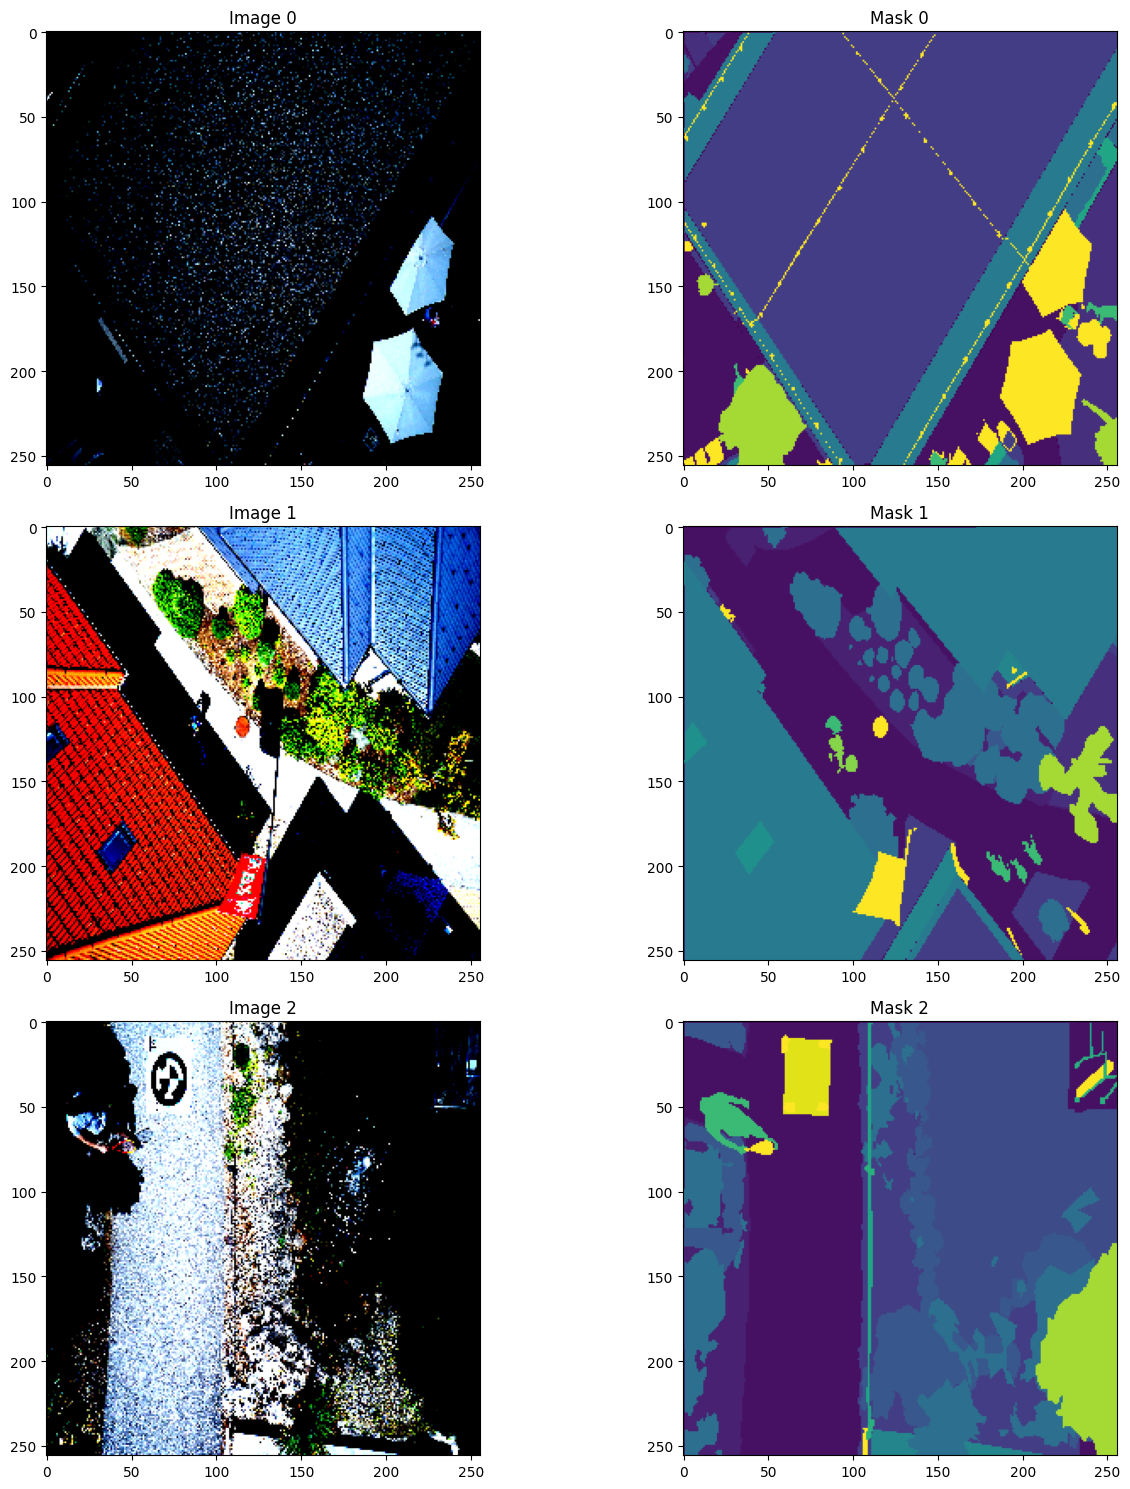

In [40]:
display_samples(train_dataset)

In [41]:
import torch


def calculate_metrics(outputs, masks, num_classes):
    with torch.no_grad():
        preds = torch.argmax(outputs, dim=1)

        # Считаем Accuracy
        correct = (preds == masks).float()
        accuracy = correct.sum() / correct.numel()

        # Находим IoU и Dice по каждому классу
        ious = []
        dices = []
        for cls in range(num_classes):
            pred_inds = (preds == cls)
            target_inds = (masks == cls)

            intersection = (pred_inds & target_inds).sum().float()
            union = (pred_inds | target_inds).sum().float()
            iou = intersection / union if union > 0 else torch.tensor(1.0)

            dice = 2 * intersection / (pred_inds.sum().float() + target_inds.sum().float()) if (pred_inds.sum() + target_inds.sum()) > 0 else torch.tensor(1.0)

            ious.append(iou)
            dices.append(dice)

        mean_iou = torch.stack(ious).mean()
        mean_dice = torch.stack(dices).mean()

    return accuracy.item(), mean_iou.item(), mean_dice.item()

### Создание бейзлайна и оценка качества

In [42]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_classes, num_epochs=10):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc_sum = 0
        train_iou_sum = 0
        train_dice_sum = 0
        train_batches = 0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.squeeze(1).long().to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            acc, iou, dice = calculate_metrics(outputs, masks, num_classes)
            train_acc_sum += acc
            train_iou_sum += iou
            train_dice_sum += dice

            train_batches += 1

        avg_train_loss = train_loss / train_batches
        avg_train_acc = train_acc_sum / train_batches
        avg_train_iou = train_iou_sum / train_batches
        avg_train_dice = train_dice_sum / train_batches

        model.eval()
        val_loss = 0
        val_acc_sum = 0
        val_iou_sum = 0
        val_dice_sum = 0
        val_batches = 0

        with torch.no_grad():
            for images_val, masks_val in val_loader:
                images_val = images_val.to(device)
                masks_val = masks_val.squeeze(1).long().to(device)

                outputs_val = model(images_val)
                loss_val = criterion(outputs_val, masks_val)

                val_loss += loss_val.item()

                acc_val, iou_val, dice_val = calculate_metrics(outputs_val, masks_val, num_classes)
                val_acc_sum += acc_val
                val_iou_sum += iou_val
                val_dice_sum += dice_val

                val_batches += 1

        avg_val_loss = val_loss / val_batches
        avg_val_acc = val_acc_sum / val_batches
        avg_val_iou = val_iou_sum / val_batches
        avg_val_dice = val_dice_sum / val_batches

        print(f"- Эпоха {epoch+1} -")
        print(f"*Train* Loss: {avg_train_loss:.3f} Acc: {avg_train_acc:.3f} IoU: {avg_train_iou:.3f} Dice: {avg_train_dice:.3f}")
        print(f"*Val* Loss: {avg_val_loss:.3f} Acc: {avg_val_acc:.3f} IoU: {avg_val_iou:.3f} Dice: {avg_val_dice:.3f}\n")

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
num_classes = 23
learning_rate = 0.001

model = smp.Unet(
    encoder_name="resnet34",
    classes=num_classes,
    encoder_weights="imagenet",
    activation=None,
    decoder_channels=[256, 128, 64, 32, 16]
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_model(model,criterion, optimizer, train_loader, val_loader, device, num_classes, num_epochs=10)

## Улучшение бейзлайна

In [49]:
class CombinedLoss(nn.Module):
    def __init__(self, ce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def dice_loss(self, predictions, targets, num_classes=11, smooth=1e-6):
        predictions = predictions.argmax(dim=1)
        dice_score = 0.0

        for class_index in range(num_classes):
            predicted_mask = (predictions == class_index).float()
            target_mask = (targets == class_index).float()
            intersection = (predicted_mask * target_mask).sum()
            dice_score += (2. * intersection + smooth) / (predicted_mask.sum() + target_mask.sum() + smooth)

        return dice_score / num_classes

    def forward(self, outputs, targets):
        ce_loss = self.cross_entropy_loss(outputs, targets)
        d_loss = self.dice_loss(outputs, targets)
        return self.ce_weight * ce_loss + self.dice_weight * d_loss

In [ ]:
batch_size = 8

improved_data_transforms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussNoise(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast((0,0.5),(0,0.5), p=0.4)])

improved_train_dataset = DroneDataset(image_path, mask_path, X_train, improved_data_transforms)
improved_valid_dataset = DroneDataset(image_path, mask_path, X_val)

improved_train_loader = DataLoader(improved_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
improved_val_loader = DataLoader(improved_valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
num_classes = 23
learning_rate = 0.0001

improved_model = smp.Unet(
    encoder_name="resnet50",
    classes=num_classes,
    encoder_weights="imagenet"
)
improved_model.to(device)

improved_criterion = CombinedLoss()
improved_optimizer = torch.optim.Adam(improved_model.parameters(), lr=learning_rate)

In [ ]:
train_model(improved_model, improved_criterion, improved_optimizer, improved_train_loader, improved_val_loader, device, num_classes, num_epochs=15)

## Имплементация алгоритма машинного обучения

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Класс для создания простого блока свертки
class SimpleConvolutionalBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


# Собственный класс Unet модели
class MyUNet(nn.Module):
    def __init__(self, output_channels=1, feature_sizes=[32, 64, 128]):
        super().__init__()
        self.encoder_blocks = nn.ModuleList()
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

        input_channels = 3
        for feature_size in feature_sizes:
            self.encoder_blocks.append(SimpleConvolutionalBlock(input_channels, feature_size))
            input_channels = feature_size

        self.bottleneck_block = SimpleConvolutionalBlock(feature_sizes[-1], feature_sizes[-1] * 2)

        self.upconvolution_layers = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        for feature_size in reversed(feature_sizes):
            self.upconvolution_layers.append(nn.ConvTranspose2d(feature_size * 2, feature_size, kernel_size=2, stride=2))
            self.decoder_blocks.append(SimpleConvolutionalBlock(feature_size * 2, feature_size))

        self.final_convolution = nn.Conv2d(feature_sizes[0], output_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pooling_layer(x)

        x = self.bottleneck_block(x)

        skip_connections.reverse()

        # Decoder
        for idx in range(len(self.upconvolution_layers)):
            x = self.upconvolution_layers[idx](x)
            skip_connection = skip_connections[idx]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_blocks[idx](x)

        return self.final_convolution(x)

In [ ]:
num_classes = 23
learning_rate = 0.001

my_model = MyUNet(output_channels=num_classes)
my_model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

In [ ]:
train_model(my_model, criterion, optimizer, train_loader, val_loader, device, num_classes, num_epochs=10)

In [ ]:
num_classes = 23
learning_rate = 0.0001

improved_my_model = MyUNet(output_channels=num_classes)
improved_my_model.to(device)

improved_criterion = CombinedLoss()
improved_optimizer = torch.optim.Adam(improved_my_model.parameters(), lr=learning_rate)

In [ ]:
train_model(improved_my_model, improved_criterion, improved_optimizer, improved_train_loader, improved_val_loader, device, num_classes, num_epochs=15)

# Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)
## Выполнил студент группы М8О-406Б-21, Карнаков Н.Д.

### Выбор начальных условий

Был использован следующий датасет - https://www.kaggle.com/datasets/sshikamaru/car-object-detection

Набор данных содержит изображения автомобилей во всех ракурсах. Практическая значимость распознавания автомобилей на фотографии состоит в обнаружении нарушителей правил дорожного движения и др.

In [51]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/sshikamaru/car-object-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nikitavorona
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection


In [57]:
train_data_path = "/content/car-object-detection/data/training_images"
test_data_path = "/content/car-object-detection/data/testing_images"
train_bboxes_csv_path = "/content/car-object-detection/data/train_solution_bounding_boxes (1).csv"

In [58]:
import pandas as pd
import numpy as np
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch
import warnings

warnings.filterwarnings("ignore")

try:
    from ultralytics import YOLO
except:
    print("Installing `ultralytics`...")
    !pip install ultralytics
    from ultralytics import YOLO

In [59]:
bboxes = pd.read_csv(train_bboxes_csv_path)
len(os.listdir(train_data_path)), bboxes.shape

(1001, (559, 5))

In [60]:
data_path = os.path.join(os.getcwd(), "data")
images_path = os.path.join(data_path, "images")
labels_path = os.path.join(data_path, "labels")

os.makedirs(images_path, exist_ok=True)
os.makedirs(labels_path, exist_ok=True)

In [61]:
class ImageReadError(Exception):
    """Custom exception for image read errors."""
    def __init__(self, message="Failed to read the image. The file might be missing or corrupted."):
        self.message = message
        super().__init__(self.message)

In [62]:
def convert_bbox_to_YOLO_format(image_path, bbox):
    try:
        image = cv2.imread(image_path)

        if image is None:
            raise ImageReadError(f"Failed to read image: {image_path}")

        (h, w) = image.shape[:2]
        xmin, ymin, xmax, ymax = bbox
        x_cen = (xmax + xmin) / 2. / w
        y_cen = (ymax + ymin) / 2. / h
        box_w = (xmax - xmin) / w
        box_h = (ymax - ymin) / h

        return (x_cen, y_cen, box_w, box_h)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return

In [63]:
for i in range(bboxes.shape[0]):
    img_path, bbox = bboxes.loc[i, "image"], bboxes.iloc[i, 1:].values
    full_img_path = os.path.join(train_data_path, img_path)
    YOLO_format_bbox = convert_bbox_to_YOLO_format(full_img_path, bbox)
    YOLO_format_bbox = np.array(YOLO_format_bbox).astype(str)

    with open(os.path.join(labels_path, f"{img_path.replace('.jpg', '')}.txt"), "w+") as f:
        f.write("0 " + " ".join(YOLO_format_bbox) + "\n")

    shutil.copy(full_img_path, os.path.join(images_path, img_path))

In [64]:
with open(os.path.join(os.getcwd(), "dataset_custom.yaml"), "w") as f:
    f.write(f"path: {data_path}\n")
    f.write("train: images\n")
    f.write("val: images\n\n")
    f.write("nc: 1\n\n")
    f.write("names: ['car']\n")

In [65]:
def display_image_with_bbox(image_path, bboxes):
    try:
        image = cv2.imread(image_path)

        if image is None:
            raise ImageReadError(f"Failed to read image: {image_path}")
        else:
            for bbox in bboxes:
                x1, y1, x2, y2 = map(int, bbox)
                # Draw rectanlge:  (start_point, end_point, color, thickness)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Dispaly an image
            plt.imshow(image_rgb)
            plt.axis("off")
            plt.title("Image with detected Car (if present)")

    except Exception as e:
        print(f"Error displaying image {image_path}: {e}")

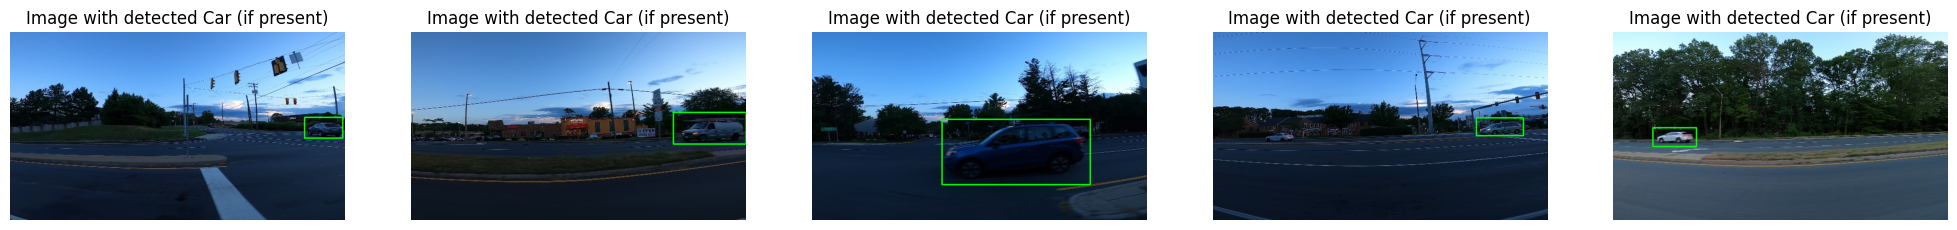

In [66]:
import random

plt.figure(figsize=(25, 5))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    idx = random.randint(0, bboxes.shape[0] - 1)
    img_path, bbox = bboxes.loc[idx, "image"], tuple(bboxes.iloc[idx, 1:].values)
    img_path = os.path.join(train_data_path, img_path)

    display_image_with_bbox(img_path, [bbox])

## Создание бейзлайна и оценка качества

In [67]:
dataset_yaml_path = os.path.join(os.getcwd(), "dataset_custom.yaml")

pretrained_weights = "yolo11n.pt"  # using YOLOv11n

epochs = 30
batch_size = 16
img_size = 640
device = "0" if torch.cuda.is_available() else "cpu"

In [ ]:
model = YOLO("yolo11n.pt")

model.train(
    data=dataset_yaml_path,
    epochs=epochs,
    batch=batch_size,
    imgsz=img_size,
    device=device,
    verbose=False
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 58.6MB/s]


Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_custom.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

100%|██████████| 755k/755k [00:00<00:00, 15.1MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    111296  ultralytics.nn.modules.block.C3k2            [384, 128, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1     32096  ultralytics.nn.modules.block.C3k2            [256, 64, 1, False]           
 17                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192,

train: Scanning /content/data/labels... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<00:00, 809.48it/s]

train: New cache created: /content/data/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1422.8±413.8 MB/s, size: 101.5 KB)


val: Scanning /content/data/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.383      3.155      1.097         34        640:  74%|███████▍  | 17/23 [04:17<01:36, 16.11s/it]

In [ ]:
metrics = model.val()
metrics_dict = metrics.results_dict

mAP_50 = metrics_dict['metrics/mAP50(B)']  # mAP at IoU=0.5
mAP_50_95 = metrics_dict['metrics/mAP50-95(B)']

print(f"\nmAP@0.5: {mAP_50}")
print(f"\nmAP@0.5:0.95: {mAP_50_95}")

precision = metrics_dict['metrics/precision(B)']
recall = metrics_dict['metrics/recall(B)']
fitness = metrics_dict['fitness']

print(f"\nPrecision: {precision}")
print(f"\nRecall: {recall}")
print(f"\nFitness: {fitness}")